In [1]:
#Librerias Julia
using RCall
using PhyloNetworks
using PhyloPlots
using DataFrames
using Random
using Plots
using TSne
using Statistics
using Distances
using Clustering

In [2]:
#Librerias de R

R"""
library("ape")
library("phangorn")
library("ggtree")       # For phylogenetic tree visualization
library("ggplot2")      # For plotting
library("gridExtra")    # For organizing plots in a grid
"""

┌ Warning: RCall.jl: Warning: package 'phangorn' was built under R version 4.4.1
└ @ RCall C:\Users\Israel\.julia\packages\RCall\dDAVd\src\io.jl:172
┌ Warning: RCall.jl: ggtree v3.12.0 For help: https://yulab-smu.top/treedata-book/
│ 
│ If you use the ggtree package suite in published research, please cite
│ the appropriate paper(s):
│ 
│ Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
│ ggtree: an R package for visualization and annotation of phylogenetic
│ trees with their covariates and other associated data. Methods in
│ Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628
│ 
│ G Yu. Data Integration, Manipulation and Visualization of Phylogenetic
│ Trees (1st ed.). Chapman and Hall/CRC. 2022. ISBN: 9781032233574
│ 
│ Guangchuang Yu.  Data Integration, Manipulation and Visualization of
│ Phylogenetic Trees (1st edition). Chapman and Hall/CRC. 2022,
│ doi:10.1201/9781003279242
│ 
│ Adjuntando el paquete: 'ggtree'
│ 
│ The following object is ma

RObject{StrSxp}
 [1] "gridExtra" "ggplot2"   "ggtree"    "phangorn"  "ape"       "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     


In [3]:
# Cargar dataset - Input
R"""
datos_dna <- read.dna("datasets/HIV2_72.phylip")
"""

RObject{RCall.RawSxp}
72 DNA sequences in binary format stored in a matrix.

All sequences of same length: 828 

Labels:
MAC_US_x_2
A_CI_88_UC
A_DE_x_BEN
A_DE_x_PEI
A_GH_x_GH1
A_GM_87_D1
...

Base composition:
    a     c     g     t 
0.330 0.180 0.283 0.208 
(Total: 59.62 kb)


┌ Warning: RCall.jl: Warning: Removed 72 rows containing missing values or values outside the scale range
│ (`geom_segment_g_gtree()`).
│ Warning: Removed 12 rows containing missing values or values outside the scale range
│ (`geom_text()`).
└ @ RCall C:\Users\Israel\.julia\packages\RCall\dDAVd\src\io.jl:172


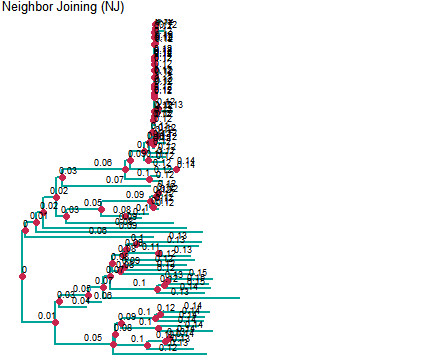

RObject{VecSxp}
TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]


In [4]:
R"""
# Convert the multiple sequence alignment result to a phyDat object for downstream analyses in phangorn
phyDat_msa_primate_sample = as.phyDat(datos_dna)

# Distance Calculation
# Calculate the Hamming distance matrix for the given aligned sequences
# This serves as a measure of pairwise sequence dissimilarity for tree construction
D_hamming = dist.hamming(phyDat_msa_primate_sample)

# Compute the Neighbor Joining tree
nj_tree = nj(D_hamming) #Aplica nj
nj_tree$edge.length[which(nj_tree$edge.length<0)]= 1 #Reemplaza los edges donde sea menor a cero por 1
# midpoint Re-root the tree at its midpoint for better visualization
# multi2di Binariza los arboles, o sea hace que de 1 padre salgan solo 2 hijos
nj_tree = midpoint(multi2di(nj_tree)) 


# Function to plot trees
plot_tree = function(tree_plot, title_plot, max_x) {
  g = ggtree(tree_plot, color = "#00A499", size = 1)
  
  # Customize the appearance of the plot and tip labels
  g = g + geom_tiplab(size = 4, color = "black", align = TRUE) +
    geom_nodepoint(size = 3, color = "#c7254e") +
    labs(title = title_plot, size = 6) +
    xlim(0, max_x) +
    theme(
      # Remove axis lines and text
      axis.line = element_blank(),
      axis.text = element_blank(),
      # Remove all grids
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      # Adjust margins and legend position
      plot.margin = margin(t = 0, r = -5, b = 0, l = 0, unit = "pt"),
      legend.position = 'top'
    )
  
  # Add labels for branch lengths with a smaller font size
  g = g + geom_text(aes(x = branch, label = round(branch, 2)), size = 3, color = "black", vjust = -0.5, hjust = 0)
  
  return(g)
}

# Create plots for the NJ tree
# Specify titles for each plot
g_NJ  = plot_tree(nj_tree, "Neighbor Joining (NJ)", 0.35)

# Organize the two plots in a one-row, two-column grid
grid.arrange(g_NJ, nrow = 1, ncol = 1)
"""

In [5]:
#Generar 100 arboles con NNI
R"""
# Se generan 100 arboles usando NNI con un solo movimiento de 1 rama
multiarboles = rNNI(nj_tree, moves = 1, n = 100)
"""

RObject{VecSxp}
100 phylogenetic trees


In [6]:
R"""
# Se asegura que estos arboles sean binarios, en caso no lo sean se binarizan
for (i in seq_along(multiarboles)) {
    # Verifica si el arbol en la posicion i no es binario
    if (!is.binary(multiarboles[[i]])) {
      # Si no es binario lo reemplaza con la version binarizada
      multiarboles[[i]] = multi2di(multiarboles[[i]])
    }
  }
"""

RObject{NilSxp}
NULL


In [7]:
# Se escribe el archivo resultante en formato newick
R"""
# Saving to Newick
write.tree(multiarboles, file="100-nj-initial.nwk")
"""

RObject{NilSxp}
NULL


In [8]:
#Una vez esto listo se generara un arbol de consenso para entrada para snaq de PhyloNetworks
R"""
# Arbol Medioide consenso
# Initialize an empty matrix for RF distances with dimensions 100x100
RF_distance_matrix = matrix(0, 100, 100)

# Calculate Robinson-Foulds (RF) distances between all pairs of trees 
for (a in 1:100) {
  for (b in 1:100) {
    # Calculate the RF distance between tree 'a' and tree 'b' and store it in the matrix
    RF_distance_matrix[a, b] = RF.dist(multiarboles[[a]], multiarboles[[b]], normalize = TRUE)
  }
}

# Find the index of the tree that minimizes the average RF distance
idx_med = which.min(colMeans(RF_distance_matrix))

# Medoid: Select the tree that corresponds to the medoid index
medoid_tree = multiarboles[[idx_med]]
#Reemplaza los edges donde sea menor a cero por 1
#medoid_tree$edge.length[which(medoid_tree$edge.length<=0)]= 1 
medoid_tree = midpoint(medoid_tree)
# Se verifica si es binario
print("Binario:")
print(is.binary(medoid_tree))
"""

[1] "Binario:"
[1] TRUE


RObject{LglSxp}
[1] TRUE


In [9]:
# Se guarda el arbol de consenso
R"""
# Saving to Newick
write.tree(medoid_tree, file="arbol-consenso-inicial.nwk")
"""

RObject{NilSxp}
NULL


## Aca hacia abajo empieza el proceso de SNAQ

In [4]:
# Caso para rbcL_55.phylip o superiores
arbolesTemp = readMultiTopology("100-nj-initial.nwk")
# Seleccionar aleatoriamente 10 elementos y modificar el vector original
arbolesTemp = arbolesTemp[randperm(length(arbolesTemp))[1:5]]

5-element Vector{HybridNetwork}:
 HybridNetwork, Rooted Network
108 edges
109 nodes: 55 tips, 0 hybrid nodes, 54 internal tree nodes.
tip labels: Cornuscan, Dipsacus, Nicotiana, Gentiana, ...
(((((((((((((((Cornuscan:0.034,Dipsacus:0.028):0.001,(Nicotiana:0.034,Gentiana:0.031):0.008):0.001,((((NothofBal:0.031,Celtis:0.023):0.012,Floerkea:0.043):0.001,Heuchera:0.024):0.001,(Gunnera:0.021,Platanus:0.021):0.005):0.002):0.006,Amaranthu:0.065):0.006,((((Hedycarya:0.02,Austrobai:0.028):0.002,Tasmannia:0.019):0.004,Saururus:0.035):0.004,Victoria:0.027):0.003):0.005,(Iris:0.028,Aloe:0.032):0.012):0.005,(Avena:0.057,Carex:0.046):0.009):0.015,(((Larix:0.014,Picea_pun:0.011):0.027,Ginkgobil:0.024):0.004,Podocarpus:0.048):0.016):0.014,(((((Cheiropleu:0.064,Loxoma:0.05):0.006,Marsilea:0.073):0.003,(((Nephrolepi:0.048,Xiphopteri:0.051):0.004,Asplenium:0.062):0.007,Monachosor:0.072):0.011):0.014,Lycopodium:0.071):0.009,(Osmunda_ci:0.062,Angiopter:0.063):0.005):0.002):0.003,Sphagnum_J:0.068):0.003,(((

In [5]:
#Julia
# Se leen los CF (Factores de Concordancia) de los 100 arboles generados
datacf = readTrees2CF(arbolesTemp)

will use all quartets on 55 taxa
calculating obsCF from 5 gene trees and for 341055 quartets
Reading in quartets...
0+--------------------------------------------------+100%  
  ****************************************  
table of obsCF printed to file tableCF.txt
descriptive stat of input data printed to file summaryTreesQuartets.txt


Object DataCF
number of quartets: 341055
number of trees: 5


In [6]:
# Se lee el arbol de consenso que se usara como punto inicial para snaq!
initialTree = readTopology("arbol-consenso-inicial.nwk")

HybridNetwork, Rooted Network
108 edges
109 nodes: 55 tips, 0 hybrid nodes, 54 internal tree nodes.
tip labels: Chlor_ell, Volvox_ro, Pyrami_pa, Cornuscan, ...
((((Chlor_ell:0.075,Volvox_ro:0.049):0.013,Pyrami_pa:0.079):0.01,(((((((((((((Cornuscan:0.034,Dipsacus:0.028):0.001,(Nicotiana:0.034,Gentiana:0.031):0.008):0.001,((((NothofBal:0.031,Celtis:0.023):0.012,Floerkea:0.043):0.001,Heuchera:0.024):0.001,(Gunnera:0.021,Platanus:0.021):0.005):0.002):0.006,Amaranthu:0.065):0.006,((((Hedycarya:0.02,Austrobai:0.028):0.002,Tasmannia:0.019):0.004,Saururus:0.035):0.004,Victoria:0.027):0.003):0.005,(Iris:0.028,Aloe:0.032):0.012):0.005,(Avena:0.057,Carex:0.046):0.009):0.015,(((Larix:0.014,Picea_pun:0.011):0.027,Ginkgobil:0.024):0.004,Podocarpus:0.048):0.016):0.014,(((Osmunda_ci:0.062,Angiopter:0.063):0.005,(((Cheiropleu:0.064,Loxoma:0.05):0.006,Marsilea:0.073):0.003,(((Nephrolepi:0.048,Xiphopteri:0.051):0.004,Asplenium:0.062):0.007,Monachosor:0.072):0.011):0.014):0.009,Lycopodium:0.071):0.002):0.

In [7]:
#phylonetwork = snaq!(initialTree, datacf, hmax=1, runs=1, filename="phylonetwork")
#Para dejar de referencia, con los parametros que estan ahi con hmax=1 y runs=1 se demoro 55 minutos en correr - primates 14

#Version que demora menos tiempo
phylonetwork = snaq!(initialTree, datacf, hmax=1, runs=1, filename="phylonetwork", ftolRel=1.0e-1, ftolAbs=1.0e-1,liktolAbs = 1.0e-1, Nfail=5)


optimization of topology, BL and inheritance probabilities using:
 hmax = 1,
 tolerance parameters: ftolRel=0.1, ftolAbs=0.1,
                       xtolAbs=0.001, xtolRel=0.01.
 max number of failed proposals = 5, liktolAbs = 0.1.
rootname for files: phylonetwork
BEGIN: 1 runs on starting tree (Chlor_ell,Volvox_ro,(Pyrami_pa,((((((((((((((Cornuscan,Dipsacus):0.001057754006,(Nicotiana,Gentiana):0.007694148582):0.0008836779602,((((NothofBal,Celtis):0.01227853215,Floerkea):0.001479463272,Heuchera):0.001338119376,(Gunnera,Platanus):0.004940419437):0.001815618082):0.005802534124,Amaranthu):0.005722063317,((((Hedycarya,Austrobai):0.002078372485,Tasmannia):0.003978552828,Saururus):0.0038327573,Victoria):0.00265563721):0.004844574369,(Iris,Aloe):0.01206529425):0.004510070514,(Avena,Carex):0.008588840247):0.01462105529,(((Larix,Picea_pun):0.02666389511,Ginkgobil):0.003556327491,Podocarpus):0.01591583206):0.0144718025,(((Osmunda_ci,Angiopter):0.004965183639,(((Cheiropleu,Loxoma):0.006239736041,

: 

In [ ]:
#(Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.04,BarbMacaq):0.744,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.632):0.662):0.646)#H17:0.0::0.85):0.0,Bovine):0.489):3.587,(Gibbon,#H17:3.501::0.15):0.0):2.13):2.489):1.566);

In [5]:
#Se carga la red conseguida
network = readTopology("(Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.0404313920703765,BarbMacaq):0.7435551393691957,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.631514612920511):0.6623373265490394):0.6461697286275412)#H17:0.0::0.8504746823085855):2.3377630939063185e-7,Bovine):0.48924458319757164):3.58679376267071,(Gibbon,#H17:3.5005007477360706::0.14952531769141453):0.0):2.1304287910826285):2.4888147361808226):1.5656090423495401);")

HybridNetwork, Rooted Network
28 edges
28 nodes: 14 tips, 1 hybrid nodes, 13 internal tree nodes.
tip labels: Chimp, Human, Gorilla, Orang, ...
(Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.04,BarbMacaq):0.744,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.632):0.662):0.646)#H17:0.0::0.85):0.0,Bovine):0.489):3.587,(Gibbon,#H17:3.501::0.15):0.0):2.13):2.489):1.566);


In [ ]:
# Se guarda la red conseguida
writeTopology(network, "phylonet.nwk")

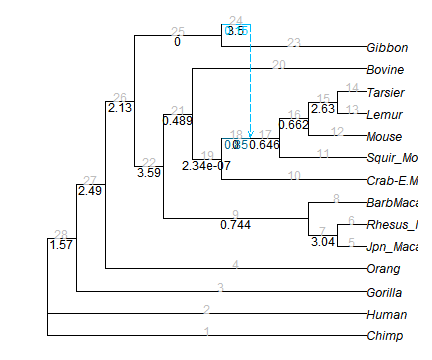

In [6]:
R"par"(mar = [0,0,0,1]);
PhyloPlots.plot(network, showgamma=true, showedgelength=true, showedgenumber=true);

In [7]:
printEdges(network)

edge parent child  length  hybrid isMajor gamma   containRoot inCycle istIdentitiable
1    -2     1              false  true    1       true        -1      false
2    -2     2              false  true    1       true        -1      false
3    -3     3              false  true    1       true        -1      false
4    -4     4              false  true    1       true        -1      false
5    -8     5              false  true    1       true        -1      false
6    -8     6              false  true    1       true        -1      false
7    -7     -8     3.040   false  true    1       true        -1      true 
8    -7     7              false  true    1       true        -1      false
9    -6     -7     0.744   false  true    1       true        -1      true 
10   -10    8              false  true    1       true        -1      false
11   -12    9              false  true    1       false       -1      false
12   -13    10             false  true    1       false       -1      false
13

In [39]:
#network.edge[1].length

-1.0

In [36]:
#size(network.edge)[1]

28

In [45]:
#network.edge

28-element Vector{PhyloNetworks.EdgeT{PhyloNetworks.Node}}:
 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:1
 length:-1.0
 attached to 2 node(s) (parent first): -2 1

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:2
 length:-1.0
 attached to 2 node(s) (parent first): -2 2

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:3
 length:-1.0
 attached to 2 node(s) (parent first): -3 3

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:4
 length:-1.0
 attached to 2 node(s) (parent first): -4 4

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:5
 length:-1.0
 attached to 2 node(s) (parent first): -8 5

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:6
 length:-1.0
 attached to 2 node(s) (parent first): -8 6

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:7
 length:3.0404313920703765
 attached to 2 node(s) (parent first): -7 -8

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:8
 length:-1.0
 attached to 2 node(s) (parent first): -7 7

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 nu

In [8]:
# Arreglar el largo perdido en los edges
for e in network.edge
    if e.length <= 0
        e.length = 1
    end
end

In [9]:
# Se guarda la red conseguida una vez arreglada
writeTopology(network, "phylonet-fixed.nwk")

In [10]:
#Arreglar la estructura del arbol - binarizarla
R"""
phylored = read.tree("phylonet-fixed.nwk")
phylored = midpoint(multi2di(phylored))
write.tree(phylored, file="red_filo_binaria.nwk")
"""

RObject{NilSxp}
NULL


In [11]:
phylonet = readTopology("red_filo_binaria.nwk")

HybridNetwork, Rooted Network
28 edges
28 nodes: 14 tips, 1 hybrid nodes, 13 internal tree nodes.
tip labels: Lemur, Tarsier, Mouse, Squir_Mon, ...
(((((((Lemur:1.0,Tarsier:1.0):2.632,Mouse:1.0):0.662,Squir_Mon:1.0)#H17:1.646,Crab-E.Ma:1.0):0.0,Bovine:1.0):0.489,((Jpn_Macaq:1.0,Rhesus_Ma:1.0):3.04,BarbMacaq:1.0):0.744):2.171,((((Human:1.0,Chimp:1.0):1.566,Gorilla:1.0):2.489,Orang:1.0):2.13,(Gibbon:1.0,#H17:3.501):1.0):1.416);


In [12]:
# Arreglar el largo perdido en los edges
for e in phylonet.edge
    if e.length <= 0
        e.length = 1
    end
end

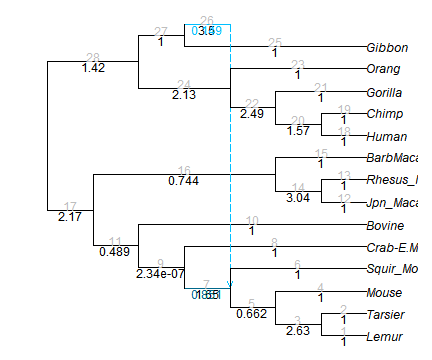

In [17]:
R"par"(mar = [0,0,0,1]);
PhyloPlots.plot(phylonet, showgamma=true, showedgelength=true, showedgenumber=true);

In [18]:
# Arreglar perdida de gamma (numeros en celeste)
printEdges(phylonet)

edge parent child  length  hybrid isMajor gamma   containRoot inCycle istIdentitiable
1    -8     1      1.000   false  true    1       false       -1      false
2    -8     2      1.000   false  true    1       false       -1      false
3    -7     -8     2.632   false  true    1       false       -1      true 
4    -7     3      1.000   false  true    1       false       -1      false
5    5      -7     0.662   false  true    1       false       -1      true 
6    5      4      1.000   false  true    1       false       -1      false
7    -5     5      1.646   true   true    0.8505  true        -1      true 
8    -5     6      1.000   false  true    1       true        -1      false
9    -4     -5     0.000   false  true    1       true        -1      true 
10   -4     7      1.000   false  true    1       true        -1      false
11   -3     -4     0.489   false  true    1       true        -1      true 
12   -10    8      1.000   false  true    1       true        -1      false
13

In [15]:
setGamma!(phylonet.edge[7], 0.8505)

In [16]:
setGamma!(phylonet.edge[26], 0.1495)

## SIN SNAQ !!!!!!



In [10]:
# Se lee el arbol de consenso que se usara como punto inicial, lo vamos a convertir en red
phylonet = readTopology("arbol-consenso-inicial.nwk")

HybridNetwork, Rooted Network
142 edges
143 nodes: 72 tips, 0 hybrid nodes, 71 internal tree nodes.
tip labels: MAC_US_x31, MAC_US_x12, MAC_US_y89, MAC_US_x59, ...
(((((((((((((((((MAC_US_x31:0.013,MAC_US_x12:1.0):0.001,MAC_US_y89:1.0):0.002,MAC_US_x59:0.001):0.0,((((((MAC_US_x2r:0.0,MAC_US_x99:0.0):0.0,MAC_US_x29:0.0):0.0,MAC_US_y79:1.0):0.0,(MAC_US_y59:0.001,MAC_US_y69:1.0):0.001):0.0,(((((MAC_US_x48:0.001,MAC_US_x19:0.002):0.0,MAC_US_x21:0.008):0.001,MAC_US_x79:1.0):0.0,(MAC_US_x_2:0.0,MAC_US_x11:0.0):0.001):0.0,MAC_US_y29:1.0):0.0):0.0,((((MAC_US_x28:0.002,MAC_US_x69:1.0):0.0,MAC_US_x1r:1.0):0.0,MAC_US_y49:1.0):0.0,MAC_US_x89:1.0):0.0):0.0):0.0,MAC_US_x38:0.001):0.0,MAC_US_x18:1.0):0.001,(((MAC_US_x49:0.004,MAC_US_y39:0.002):0.003,MAC_US_y19:0.009):0.001,MAC_US_x39:0.001):0.0):0.003,MAC_US_x22:0.015):0.005,(MAC_US_x32:0.013,MAC_US_x42:0.015):0.004):0.012,(MAC_US_x_M:0.002,MAC_US_x_S:0.001):0.041):0.004,(MNE_US_82_:0.011,MNE_US_x_M:0.008):0.021):0.056,SMM_US_x5P:0.079):0.005,(((SMM_

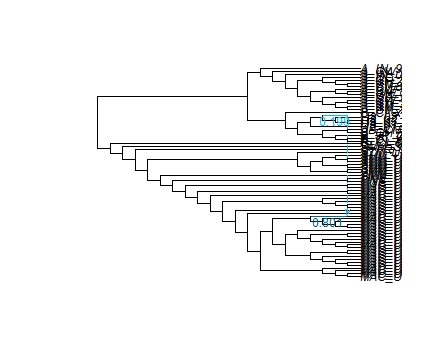

In [13]:
PhyloPlots.plot(phylonet, showgamma=true);

In [12]:
# Esta funcion literalmente toma un arbol filogenetico y bum, lo convierte en red filogenetica de forma random
PhyloNetworks.addhybridedge!(phylonet, true, true)

(PhyloNetworks.Node:
 number:74
 name:H1
 hybrid node
 attached to 3 edges, numbered: 40 144 145
, PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:145
 length:0.01
 minor hybrid edge with gamma=0.1994438501824185
 attached to 2 node(s) (parent first): 73 74
)

# Una vez conseguida y arreglada la red inicial - se procede a efectuar:
# NNI para conseguir 100 redes filogeneticas distintas - Calcular parsimonia y verosimilitud
# Armar frente de pareto

In [ ]:
# Utilitario para convertir phylip a fasta para rapidamente conseguir los elementos que se necesitan
#R"""
#datos_dna = read.dna("archivo.phylip")
#write.FASTA(datos_dna,"archivo.fasta")
#"""

In [15]:
# Funcion para arreglar datasets y eliminar signos de pregunta
R"""
replace_question_marks <- function(input_file, output_file) {
  # Leer el archivo como texto line por line
  lines <- readLines(input_file)
  
  # Reemplazar todos los signos de pregunta por guiones
  lines <- gsub("\\?", "-", lines)
  
  # Guardar el archivo modificado
  writeLines(lines, output_file)
  
  cat("El archivo ha sido modificado y guardado como:", output_file, "\n")
}
"""

RObject{ClosSxp}
function (input_file, output_file) 
{
    lines <- readLines(input_file)
    lines <- gsub("\\?", "-", lines)
    writeLines(lines, output_file)
    cat("El archivo ha sido modificado y guardado como:", 
        output_file, "\n")
}


In [16]:
R"""
replace_question_marks("./datasets/rbcL_55.phylip", "./datasets/rbcL_55.phylip")
"""

El archivo ha sido modificado y guardado como: ./datasets/rbcL_55.phylip 


RObject{NilSxp}
NULL


In [14]:
R"""
datos_dna = read.dna("datasets/HIV2_72.phylip")
write.FASTA(datos_dna,"datasets/HIV2_72.fasta")
"""

RObject{NilSxp}
NULL


In [15]:
species, traits = PhyloNetworks.readFastaToArray("datasets/HIV2_72.fasta")

(["MAC_US_x_2", "A_CI_88_UC", "A_DE_x_BEN", "A_DE_x_PEI", "A_GH_x_GH1", "A_GM_87_D1", "A_GM_x_ISY", "A_GM_x_MCN", "A_GM_x_MCR", "A_GW_86_FG"  …  "SMM_SL_92_", "SMM_US_x_F", "SMM_US_x_H", "SMM_US_x1P", "SMM_US_x2P", "SMM_US_x3P", "SMM_US_x4P", "SMM_US_x5P", "SMM_US_x_S", "STM_US_89_"], BioSequences.BioSequence[ATGGGTGGAGCTATTTCCATGAGGCGGTCCAGGCCGTCT…CTTAACATGGCTGACAAGAAGGAAACTCGC------TGA, ATGGGTGCGAGTGGATCCAAGAAGCTTTCCAAGCAATCG…CCATATAGTGAA------------------------TAA, ATGGGTGCGAGTGGATCCAAGAAGCTTTCCAAGCATTCG…CCATATAGTGAA------------------------TAA, ATGGGTGCGAGTGGATCCAAGAAGTGCTCCAGGTCCTTG…CCATTTAGT---------------------------TAA, ATGGGGGCGAGTGGATCCAAGAAGCATTCCAAGCATTCG…CCATATAGT---------------------------TAA, ATGGGTGCGAGTGGATCCAAGAAGCGTTCCGAGCATTCG…CCATATAGTGAA------------------------TAA, ATGGGTGCGAGTGGATCCAAGAAGCGTTCCAGGCCCTCG…CCATTTAGT---------------------------TAA, ATGGGTGCGAGTGGATCCAAGGAGCGTTCCAGGCCTTCG…CCATTTAGT---------------------------TAG, ATGGGTGCGAGTGGATCCAAGGAGCGTTCCAGGCCTTCG…C

In [16]:
species

72-element Vector{String}:
 "MAC_US_x_2"
 "A_CI_88_UC"
 "A_DE_x_BEN"
 "A_DE_x_PEI"
 "A_GH_x_GH1"
 "A_GM_87_D1"
 "A_GM_x_ISY"
 "A_GM_x_MCN"
 "A_GM_x_MCR"
 "A_GW_86_FG"
 "A_GW_87_CA"
 "A_GW_x_ALI"
 "A_GW_x_MDS"
 ⋮
 "MNE_US_82_"
 "MNE_US_x_M"
 "SMM_SL_92_"
 "SMM_US_x_F"
 "SMM_US_x_H"
 "SMM_US_x1P"
 "SMM_US_x2P"
 "SMM_US_x3P"
 "SMM_US_x4P"
 "SMM_US_x5P"
 "SMM_US_x_S"
 "STM_US_89_"

In [17]:
traits

72-element Vector{BioSequences.BioSequence}:
 ATGGGTGGAGCTATTTCCATGAGGCGGTCCAGGCCGTCT…CTTAACATGGCTGACAAGAAGGAAACTCGC------TGA
 ATGGGTGCGAGTGGATCCAAGAAGCTTTCCAAGCAATCG…CCATATAGTGAA------------------------TAA
 ATGGGTGCGAGTGGATCCAAGAAGCTTTCCAAGCATTCG…CCATATAGTGAA------------------------TAA
 ATGGGTGCGAGTGGATCCAAGAAGTGCTCCAGGTCCTTG…CCATTTAGT---------------------------TAA
 ATGGGGGCGAGTGGATCCAAGAAGCATTCCAAGCATTCG…CCATATAGT---------------------------TAA
 ATGGGTGCGAGTGGATCCAAGAAGCGTTCCGAGCATTCG…CCATATAGTGAA------------------------TAA
 ATGGGTGCGAGTGGATCCAAGAAGCGTTCCAGGCCCTCG…CCATTTAGT---------------------------TAA
 ATGGGTGCGAGTGGATCCAAGGAGCGTTCCAGGCCTTCG…CCATTTAGT---------------------------TAG
 ATGGGTGCGAGTGGATCCAAGGAGCGTTCCAGGCCTTCG…CCATTTAGT---------------------------TAG
 ATGGGTGCGAGTGGATCCAAGAAGCGTTCCAAGCCCTTG…CCATTTAGT---------------------------TAA
 ATGGGTGCGAGTGGATCCAAGAAGCGTTCCAGGCCGCTG…CCATTTAGT---------------------------TAA
 ATGGGTGCGAGTGGATCCAAGAAGCGTTCCGGGCCTTTG…CCATTTAGT------AAGAACAG

In [18]:
dna_dat, dna_weights = PhyloNetworks.readfastatodna("datasets/HIV2_72.fasta", false)

(72×829 DataFrame
 Row │ taxon       x1   x2   x3   x4   x5   x6   x7   x8   x9   x10  x11  x12  ⋯
     │ String      DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ MAC_US_x_2  A    T    G    G    G    T    G    G    A    G    C    T    ⋯
   2 │ A_CI_88_UC  A    T    G    G    G    T    G    C    G    A    G    T
   3 │ A_DE_x_BEN  A    T    G    G    G    T    G    C    G    A    G    T
   4 │ A_DE_x_PEI  A    T    G    G    G    T    G    C    G    A    G    T
   5 │ A_GH_x_GH1  A    T    G    G    G    G    G    C    G    A    G    T    ⋯
   6 │ A_GM_87_D1  A    T    G    G    G    T    G    C    G    A    G    T
   7 │ A_GM_x_ISY  A    T    G    G    G    T    G    C    G    A    G    T
   8 │ A_GM_x_MCN  A    T    G    G    G    T    G    C    G    A    G    T
   9 │ A_GM_x_MCR  A    T    G    G    G    T    G    C    G    A    G    T    ⋯
  10 │ A_GW_86_FG  A    T    G    G    G

In [19]:
dna_dat

Row,taxon,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,⋯
,String,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,DNA,⋯
1,MAC_US_x_2,A,T,G,G,G,T,G,G,A,G,C,T,A,T,T,T,C,C,A,T,G,A,G,G,C,G,G,T,C,C,A,G,G,C,C,G,T,C,T,G,G,A,G,A,T,C,T,G,C,G,A,C,A,G,A,G,A,C,T,C,T,T,G,C,G,G,G,C,G,C,G,T,G,G,G,G,A,G,-,-,-,A,C,T,T,A,T,G,G,G,A,G,A,C,T,C,T,T,A,⋯
2,A_CI_88_UC,A,T,G,G,G,T,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,A,A,G,C,T,T,T,C,C,A,A,G,C,A,A,T,C,G,C,A,A,G,G,A,C,T,G,C,G,A,G,A,G,A,G,A,C,T,C,T,T,G,C,G,G,G,C,G,C,G,T,G,G,A,G,G,G,-,-,-,G,G,T,T,A,T,G,T,A,A,G,G,C,A,G,T,G,C,⋯
3,A_DE_x_BEN,A,T,G,G,G,T,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,A,A,G,C,T,T,T,C,C,A,A,G,C,A,T,T,C,G,C,G,A,G,G,A,C,T,A,C,G,A,G,A,G,A,G,A,C,T,C,T,T,G,C,G,G,G,C,G,C,G,T,G,G,G,G,A,T,-,-,-,G,G,T,T,A,T,G,G,G,A,A,G,C,A,G,C,G,C,⋯
4,A_DE_x_PEI,A,T,G,G,G,T,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,A,A,G,T,G,C,T,C,C,A,G,G,T,C,C,T,T,G,C,A,A,G,G,A,C,T,A,C,G,A,G,A,G,A,G,A,C,T,C,T,T,G,C,G,A,G,C,G,C,G,T,G,G,A,G,A,G,-,-,-,A,C,T,T,G,T,G,G,G,G,G,G,C,A,A,T,G,G,⋯
5,A_GH_x_GH1,A,T,G,G,G,G,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,A,A,G,C,A,T,T,C,C,A,A,G,C,A,T,T,C,G,C,A,A,A,G,A,C,T,A,C,G,A,G,A,G,A,G,A,C,T,C,T,T,G,C,G,A,G,C,G,C,A,T,G,G,G,G,G,G,-,-,-,G,G,T,T,A,T,G,T,G,C,A,G,C,A,G,T,G,C,⋯
6,A_GM_87_D1,A,T,G,G,G,T,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,A,A,G,C,G,T,T,C,C,G,A,G,C,A,T,T,C,G,C,A,A,G,G,A,C,T,G,C,G,A,G,A,G,A,G,A,C,T,A,T,T,G,C,G,G,G,C,G,C,G,T,G,G,A,G,G,G,-,-,-,G,G,T,T,A,T,G,T,G,A,A,G,C,A,G,C,G,C,⋯
7,A_GM_x_ISY,A,T,G,G,G,T,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,A,A,G,C,G,T,T,C,C,A,G,G,C,C,C,T,C,G,C,G,A,G,G,G,T,T,A,C,A,A,G,A,G,A,G,A,C,T,C,T,T,A,C,G,A,G,C,G,C,G,G,G,G,A,G,G,A,-,-,-,G,C,T,T,G,T,G,G,G,G,G,G,C,T,C,T,G,G,⋯
8,A_GM_x_MCN,A,T,G,G,G,T,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,G,A,G,C,G,T,T,C,C,A,G,G,C,C,T,T,C,G,C,A,A,G,G,G,C,T,A,C,G,A,G,A,G,A,G,A,C,T,C,T,T,G,C,G,G,G,C,A,C,G,T,G,G,A,G,A,G,-,-,-,A,C,T,T,G,T,G,G,G,G,G,G,C,A,C,T,G,C,⋯
9,A_GM_x_MCR,A,T,G,G,G,T,G,C,G,A,G,T,G,G,A,T,C,C,A,A,G,G,A,G,C,G,T,T,C,C,A,G,G,C,C,T,T,C,G,C,A,A,G,G,G,C,T,A,C,G,A,G,A,G,A,G,A,C,T,C,T,T,G,C,G,G,G,C,A,C,G,T,G,G,A,G,A,G,-,-,-,A,C,T,T,G,T,G,G,G,G,G,G,C,A,C,T,G,C,⋯


In [20]:
dna_weights

828-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [21]:
mJC69 = JC69([0.25], false);

In [29]:
mJC69

Jukes and Cantor 69 Substitution Model,
absolute rate version
off-diagonal rates equal to 0.25/3.
rate matrix Q:
               A       C       G       T
       A       *  0.0833  0.0833  0.0833
       C  0.0833       *  0.0833  0.0833
       G  0.0833  0.0833       *  0.0833
       T  0.0833  0.0833  0.0833       *

In [112]:
phylonet

HybridNetwork, Rooted Network
111 edges
111 nodes: 55 tips, 1 hybrid nodes, 55 internal tree nodes.
tip labels: Chlor_ell, Volvox_ro, Pyrami_pa, Cornuscan, ...
((((Chlor_ell:0.075,Volvox_ro:0.049):0.013,Pyrami_pa:0.079):0.01,(((((((((((((Cornuscan:0.034,Dipsacus:0.028):0.001,(Nicotiana:0.034,Gentiana:0.031):0.008):0.001,((((NothofBal:0.031,Celtis:0.023):0.012,Floerkea:0.043):0.001,Heuchera:0.024):0.001,(Gunnera:0.021,Platanus:0.021):0.005):0.002):0.006,Amaranthu:0.065):0.006,((((Hedycarya:0.02,Austrobai:0.028):0.002,Tasmannia:0.019):0.004,Saururus:0.035):0.004,Victoria:0.027):0.003):0.005,(Iris:0.028,Aloe:0.032):0.012):0.005,(Avena:0.057,Carex:0.046):0.009):0.015,(((Larix:0.014,Picea_pun:0.011):0.027,Ginkgobil:0.024):0.004,Podocarpus:0.048):0.016):0.014,(((Osmunda_ci:0.062,Angiopter:0.063):0.005,(((Cheiropleu:0.064,Loxoma:0.05):0.006,Marsilea:0.073):0.003,(((Nephrolepi:0.048,Xiphopteri:0.051):0.004,Asplenium:0.062):0.007,Monachosor:0.072):0.011):0.014):0.009,Lycopodium:0.071):0.002):0.

In [97]:
printEdges(phylonet)

edge parent child  length  hybrid isMajor gamma   containRoot inCycle istIdentitiable
1    -5     1      0.075   false  true    1       true        -1      false
2    -5     2      0.049   false  true    1       true        -1      false
3    -4     -5     0.013   false  true    1       true        -1      true 
4    -4     3      0.079   false  true    1       true        -1      false
5    -3     -4     0.010   false  true    1       true        -1      true 
6    -18    4      0.034   false  true    1       true        -1      false
7    -18    5      0.028   false  true    1       true        -1      false
8    -17    -18    0.001   false  true    1       true        -1      true 
9    -19    6      0.034   false  true    1       true        -1      false
10   -19    7      0.031   false  true    1       true        -1      false
11   -17    -19    0.008   false  true    1       true        -1      true 
12   -16    -17    0.001   false  true    1       true        -1      true 
13

In [22]:
# Calcula verosimilitud
d1 = PhyloNetworks.fitdiscrete(phylonet, mJC69, dna_dat, dna_weights)

PhyloNetworks.StatisticalSubstitutionModel:
Jukes and Cantor 69 Substitution Model,
  absolute rate version
  off-diagonal rates equal to 0.25269/3.
  rate matrix Q:
                 A       C       G       T
         A       *  0.0842  0.0842  0.0842
         C  0.0842       *  0.0842  0.0842
         G  0.0842  0.0842       *  0.0842
         T  0.0842  0.0842  0.0842       *
on a network with 1 reticulations
data:
  72 species
  828 sites
log-likelihood: -18313.87905

In [28]:
# Calcula verosimilitud
#tolerance values to control when the optimization is stopped: 
#ftolRel (1e-12), ftolAbs (1e-10) on the likelihood, and xtolRel (1e-10), xtolAbs (1e-10) on the model parameters.
d1 = PhyloNetworks.fitdiscrete(phylonet, mJC69, dna_dat, dna_weights, ftolRel=1e-05, ftolAbs=1e-05, xtolRel=1e-05, xtolAbs=1e-05)

PhyloNetworks.StatisticalSubstitutionModel:
Jukes and Cantor 69 Substitution Model,
  absolute rate version
  off-diagonal rates equal to 0.25275/3.
  rate matrix Q:
                 A       C       G       T
         A       *  0.0842  0.0842  0.0842
         C  0.0842       *  0.0842  0.0842
         G  0.0842  0.0842       *  0.0842
         T  0.0842  0.0842  0.0842       *
on a network with 1 reticulations
data:
  72 species
  828 sites
log-likelihood: -18313.87911

In [24]:
mHKY85 = HKY85([0.5, 0.5], [0.20, 0.30, 0.30, 0.20], false)

HKY85 Substitution Model base frequencies: [0.2, 0.3, 0.3, 0.2]
absolute rate version with transition/transversion ratio kappa = a/b = 1.0
 with rates a = 0.5 and b = 0.5
rate matrix Q:
               A       C       G       T
       A       *  0.1500  0.1500  0.1000
       C  0.1000       *  0.1500  0.1000
       G  0.1000  0.1500       *  0.1000
       T  0.1000  0.1500  0.1500       *

In [26]:
d2 = PhyloNetworks.fitdiscrete(phylonet, mHKY85, dna_dat, dna_weights)

PhyloNetworks.StatisticalSubstitutionModel:
HKY85 Substitution Model base frequencies: [0.2, 0.3, 0.3, 0.2]
  absolute rate version with transition/transversion ratio kappa = a/b = 1.21035
   with rates a = 0.19494 and b = 0.16106
  rate matrix Q:
                 A       C       G       T
         A       *  0.0483  0.0585  0.0322
         C  0.0322       *  0.0483  0.0390
         G  0.0390  0.0483       *  0.0322
         T  0.0322  0.0585  0.0483       *
on a network with 1 reticulations
data:
  19 species
  1779 sites
log-likelihood: -12455.88832

In [114]:
d1.loglik

-25995.0021236889

In [30]:
# Calcula parsimonia
parsimonySoftwired(phylonet, species, traits)

2636.0

In [29]:
#Printear cantidad de ramas - edges
edgenumber = size(phylonet.edge)[1]

145

In [117]:
edgenumber

111

In [31]:
originalInitialNetwork = deepcopy(phylonet)

HybridNetwork, Rooted Network
145 edges
145 nodes: 72 tips, 1 hybrid nodes, 72 internal tree nodes.
tip labels: MAC_US_x31, MAC_US_x12, MAC_US_y89, MAC_US_x59, ...
(((((((((((((((((MAC_US_x31:0.013,MAC_US_x12:1.0):0.001,MAC_US_y89:1.0):0.002,MAC_US_x59:0.001):0.0,((((((MAC_US_x2r:0.0,MAC_US_x99:0.0):0.0,MAC_US_x29:0.0):0.0,MAC_US_y79:1.0):0.0,(MAC_US_y59:0.001,MAC_US_y69:1.0):0.001):0.0,(((((MAC_US_x48:0.001,MAC_US_x19:0.002):0.0,MAC_US_x21:0.008):0.001,MAC_US_x79:1.0):0.0,(MAC_US_x_2:0.0,MAC_US_x11:0.0):0.001):0.0,MAC_US_y29:1.0):0.0):0.0,((((MAC_US_x28:0.002,MAC_US_x69:1.0):0.0,MAC_US_x1r:1.0):0.0,MAC_US_y49:1.0):0.0,(MAC_US_x89:0.5)#H1:0.5::0.801):0.0):0.0):0.0,MAC_US_x38:0.001):0.0,MAC_US_x18:1.0):0.001,(((MAC_US_x49:0.004,MAC_US_y39:0.002):0.003,MAC_US_y19:0.009):0.001,MAC_US_x39:0.001):0.0):0.003,MAC_US_x22:0.015):0.005,(MAC_US_x32:0.013,MAC_US_x42:0.015):0.004):0.012,(MAC_US_x_M:0.002,MAC_US_x_S:0.001):0.041):0.004,(MNE_US_82_:0.011,MNE_US_x_M:0.008):0.021):0.056,SMM_US_x5P:0.07

In [32]:
parsimonyScores = []
pseudolikelihoods = []
generatedNetworks = []
networksLabel = []

for i in 1:100
    #Hacer nni
    rnd = rand(1:edgenumber)
    nni!(phylonet, phylonet.edge[rnd], true, true);
    #println(phylonet)
    
    # Hacer copia de la red generada
    auxnet = deepcopy(phylonet)

    # Calcular parsimonia de la nueva red
    parsimonyScore = parsimonySoftwired(phylonet, species, traits)

    # Calcular pseudolikelihood de la nueva red
    fit1 = PhyloNetworks.fitdiscrete(phylonet, mJC69, dna_dat, dna_weights, ftolRel=1e-05, ftolAbs=1e-05, xtolRel=1e-05, xtolAbs=1e-05)
    pseudoLikelihood = fit1.loglik

    # Guardar etiqueta de la red
    push!(networksLabel, "Network $i")
    
    # Guardar resultados
    push!(generatedNetworks, auxnet)
    push!(parsimonyScores, parsimonyScore)
    push!(pseudolikelihoods, pseudoLikelihood)
end

In [35]:
parsimonyScores

100-element Vector{Any}:
 2646.0
 2643.0
 2648.0
 2648.0
 2648.0
 2650.0
 2650.0
 2678.0
 2681.0
 2681.0
 2679.0
 2679.0
 2679.0
    ⋮
 3070.0
 3070.0
 3070.0
 3070.0
 3070.0
 3070.0
 3070.0
 3059.0
 3059.0
 3059.0
 3062.0
 2833.0

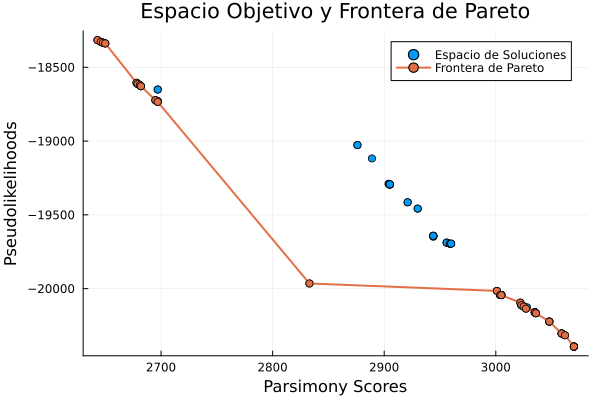

In [36]:
# Crear un DataFrame con los datos, incluyendo las redes generadas
df_plot = DataFrame(parsimonyScores = parsimonyScores, pseudolikelihoods = pseudolikelihoods, networksLabel = networksLabel)

# Ordenar por parsimonyScores y luego por pseudolikelihoods
sort!(df_plot, [:parsimonyScores, :pseudolikelihoods])

# Encontrar la frontera de Pareto minimizando ambas métricas
pareto_front = DataFrame(parsimonyScores = Int[], pseudolikelihoods = Float64[], networksLabel = String[])
min_likelihood = Inf
for row in eachrow(df_plot)
    if row.pseudolikelihoods < min_likelihood
        push!(pareto_front, row)
        min_likelihood = row.pseudolikelihoods
    end
end

# Graficar los puntos y la frontera de Pareto
Plots.scatter(df_plot.parsimonyScores, df_plot.pseudolikelihoods, label = "Espacio de Soluciones", legend = :topright)
Plots.plot!(pareto_front.parsimonyScores, pareto_front.pseudolikelihoods, label = "Frontera de Pareto", lw = 2, marker = :circle)

xlabel!("Parsimony Scores")
ylabel!("Pseudolikelihoods")
title!("Espacio Objetivo y Frontera de Pareto")

In [37]:
# Mostrar las redes generadas en la frontera de Pareto
println("Redes en la frontera de Pareto:")
println(pareto_front.networksLabel)

Redes en la frontera de Pareto:
["Network 2", "Network 1", "Network 3", "Network 6", "Network 8", "Network 11", "Network 9", "Network 14", "Network 16", "Network 18", "Network 100", "Network 50", "Network 58", "Network 59", "Network 63", "Network 64", "Network 70", "Network 69", "Network 81", "Network 84", "Network 88", "Network 98", "Network 99", "Network 89"]


In [38]:
pareto_front

Row,parsimonyScores,pseudolikelihoods,networksLabel
,Int64,Float64,String
1,2643,-18315.3,Network 2
2,2646,-18327.1,Network 1
3,2648,-18333.3,Network 3
4,2650,-18337.8,Network 6
5,2678,-18604.7,Network 8
6,2679,-18612.1,Network 11
7,2681,-18620.9,Network 9
8,2682,-18628.3,Network 14
9,2695,-18723.0,Network 16


# Listo el espacio objetivo

# Ahora toca armar el espacio de decision

In [39]:
function calculate_distance_matrix(generatedNetworks, flag=true)
    num_networks = length(generatedNetworks)
    distance_matrix = zeros(Float64, num_networks, num_networks)

    for i in 1:num_networks
        for j in i+1:num_networks
            distance = hardwiredClusterDistance(generatedNetworks[i], generatedNetworks[j], flag)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Matriz simétrica
        end
    end

    return distance_matrix
end


calculate_distance_matrix (generic function with 2 methods)

In [40]:
matriz_distancia = calculate_distance_matrix(generatedNetworks)

100×100 Matrix{Float64}:
  0.0   2.0   4.0   4.0   4.0   6.0  …  84.0  84.0  84.0  86.0  86.0  76.0
  2.0   0.0   2.0   2.0   2.0   4.0     82.0  82.0  82.0  84.0  84.0  74.0
  4.0   2.0   0.0   0.0   0.0   2.0     80.0  80.0  80.0  82.0  82.0  72.0
  4.0   2.0   0.0   0.0   0.0   2.0     80.0  80.0  80.0  82.0  82.0  72.0
  4.0   2.0   0.0   0.0   0.0   2.0     80.0  80.0  80.0  82.0  82.0  72.0
  6.0   4.0   2.0   2.0   2.0   0.0  …  80.0  80.0  80.0  82.0  82.0  72.0
  8.0   6.0   4.0   4.0   4.0   2.0     78.0  78.0  78.0  80.0  80.0  70.0
 10.0   8.0   6.0   6.0   6.0   4.0     78.0  78.0  78.0  80.0  80.0  70.0
 12.0  10.0   8.0   8.0   8.0   6.0     76.0  76.0  76.0  78.0  80.0  70.0
 12.0  10.0   8.0   8.0   8.0   6.0     76.0  76.0  76.0  78.0  80.0  70.0
 14.0  12.0  10.0  10.0  10.0   8.0  …  74.0  74.0  74.0  76.0  78.0  68.0
 14.0  12.0  10.0  10.0  10.0   8.0     74.0  74.0  74.0  76.0  78.0  68.0
 14.0  12.0  10.0  10.0  10.0   8.0     74.0  74.0  74.0  76.0  78.0  68.0


In [41]:
# Función para aplicar t-SNE a la matriz de distancia
function apply_tsne(distance_matrix; dims=2, perplexity=30.0)
    max_iter = 1000
    reduce_dims = 0
    tsne_result = tsne(distance_matrix, dims, reduce_dims, max_iter, perplexity; distance=true)
    return tsne_result
end

apply_tsne (generic function with 1 method)

In [42]:
# Aplicar t-SNE a la matriz de distancia
tsne_result = apply_tsne(matriz_distancia)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\Israel\.julia\packages\ProgressMeter\dMfiC\src\ProgressMeter.jl:594
Computing t-SNE 100%|████████████████████████████████████| Time: 0:00:00
  KL_divergence:  0.2854


100×2 Matrix{Float64}:
  -85.0505  -60.0009
  -87.955   -51.4594
  -96.9149  -50.9433
 -124.139   -59.8414
 -109.599   -39.6537
 -100.835   -41.3516
 -104.662   -48.8567
 -115.285   -60.2931
 -113.245   -47.2505
  -92.4825  -43.6336
 -107.152   -62.4828
 -109.786   -54.8527
  -94.3022  -59.1074
    ⋮       
   98.4363   41.0288
  108.96     29.9145
  102.676    54.4162
   94.295    57.8678
  106.347    38.4489
  104.995    46.2594
   87.8257   51.7926
   96.6264   48.8227
  115.234    36.8043
  114.018    45.5726
  111.935    54.162
  107.394    65.6895

In [43]:
# Calcular el coeficiente de silueta para diferentes valores de k
function calculate_silhouette_scores(data_matrix, max_k)
    silhouette_scores = Float64[]
    for k in 2:max_k
        result = kmeans(data_matrix, k)
        D = pairwise(SqEuclidean(), data_matrix, dims=2)
        score = mean(silhouettes(result.assignments, D))
        push!(silhouette_scores, score)
    end
    return silhouette_scores
end

calculate_silhouette_scores (generic function with 1 method)

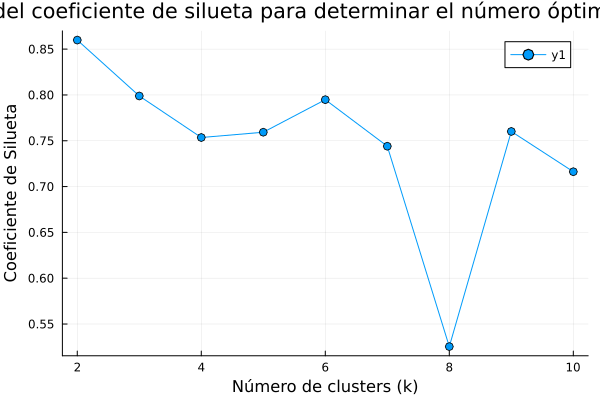

In [60]:
max_k = 10  # Podemos ajustar este valor según sea necesario
silhouette_scores = calculate_silhouette_scores(matriz_distancia, max_k)

# Graficar el coeficiente de silueta en función de k para encontrar el valor óptimo
Plots.plot(2:max_k, silhouette_scores, marker=:o, title="Método del coeficiente de silueta para determinar el número óptimo de clusters",
     xlabel="Número de clusters (k)", ylabel="Coeficiente de Silueta")

In [61]:
# Aplicar KMeans clustering con el número óptimo de clusters
# Seleccionar el número óptimo de clusters a partir del gráfico
#optimal_k = argmax(silhouette_scores) + 1
optimal_k = 5

result = kmeans(matriz_distancia, optimal_k)

# Paso 4: Visualización de los resultados en el espacio 2D original
# Aquí asumimos que la visualización será en función de los dos primeros índices de la matriz original
#Plot.scatter(data_matrix[:, 1], data_matrix[:, 2], group=result.assignments, 
#        legend=:top, title="Clustering con número óptimo de clusters", xlabel="Index 1", ylabel="Index 2")

# Mostrar las asignaciones de clusters
println("Número óptimo de clusters: ", optimal_k)
println("Asignaciones de clusters: ", result.assignments)

Número óptimo de clusters: 5
Asignaciones de clusters: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [62]:
# Visualizar el resultado de t-SNE con los clusters
scatter(tsne_result[:, 1], tsne_result[:, 2], group=result.assignments, title="t-SNE con Clusters", xlabel="Dimension 1", ylabel="Dimension 2", legend=:topright)

# Agregar una leyenda que indique los clusters
for i in 1:optimal_k
    scatter!(tsne_result[result.assignments .== i, 1], tsne_result[result.assignments .== i, 2], label="Cluster $i")
end

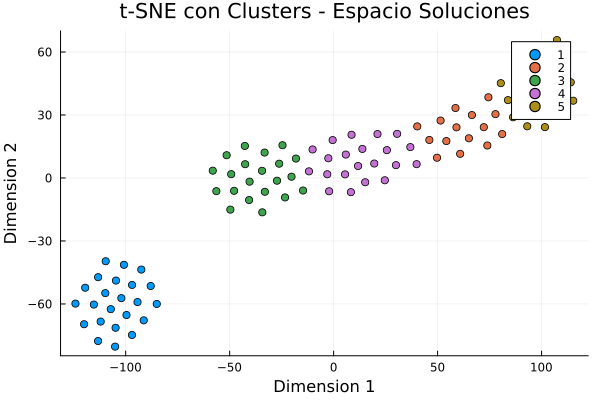

In [63]:
scatter(tsne_result[:, 1], tsne_result[:, 2], group=result.assignments, title="t-SNE con Clusters - Espacio Soluciones", xlabel="Dimension 1", ylabel="Dimension 2", legend=:topright)

# Se repite lo mismo para el espacio objetivo, necesitamos clucksterizar para aplicar jaccard

In [64]:
# Ocupando distancia euclidiana se hace una matriz de distancia usando al mismo tiempo
# Parsimonia y verosimilitud

# Crear una matriz combinando los puntajes de parsimonia y verosimilitud
combined_scores = [parsimonyScores pseudolikelihoods]

# Calcular la matriz de distancia euclidiana
distance_matrix_euclidean = zeros(Float64, length(parsimonyScores), length(parsimonyScores))

for i in 1:length(parsimonyScores)
    for j in 1:length(parsimonyScores)
        distance_matrix_euclidean[i, j] = euclidean(combined_scores[i, :], combined_scores[j, :])
    end
end

# Para visualizar los resultados
println("Matriz de distancia euclidiana:")

Matriz de distancia euclidiana:


In [65]:
distance_matrix_euclidean

100×100 Matrix{Float64}:
    0.0        12.1342     6.59131  …  2019.75      2031.99    1648.68
   12.1342      0.0       18.7182      2031.88      2044.11    1660.71
    6.59131    18.7182     0.0         2013.2       2025.43    1642.22
    6.59131    18.7182     0.0         2013.2       2025.43    1642.22
    6.59131    18.7182     0.0         2013.2       2025.43    1642.22
   11.4713     23.5721     4.89773  …  2008.41      2020.65    1637.55
   11.4713     23.5721     4.89773     2008.41      2020.65    1637.55
  279.518     291.546    273.053       1741.58      1753.82    1369.17
  295.873     307.907    289.403       1725.2       1737.44    1352.82
  295.873     307.907    289.403       1725.2       1737.44    1352.82
  286.993     299.022    280.527    …  1734.13      1746.38    1361.69
  286.993     299.022    280.527       1734.13      1746.38    1361.69
  286.993     299.022    280.527       1734.13      1746.38    1361.69
    ⋮                               ⋱               

In [66]:
# Se ocupa como hipotesis que los espacios son iguales, asi que la cantidad de clusters sera la misma aca

# Aplicar KMeans clustering con el número óptimo de clusters
# Seleccionar el número óptimo de clusters a partir del gráfico
#optimal_k_eo = argmax(silhouette_scores_eo) + 1
#optimal_k_eo = 7 # A la fuerza, borrar luego
result_eo = kmeans(distance_matrix_euclidean, optimal_k)

# Mostrar las asignaciones de clusters
println("Número óptimo de clusters: ", optimal_k)
println("Asignaciones de clusters: ", result_eo.assignments)

Número óptimo de clusters: 5
Asignaciones de clusters: [2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [67]:
result_eo_assignments = result_eo.assignments
result_assignments = result.assignments

100-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5

# Vamos a ignorar el grafico aca, directo a jaccard

In [68]:
# Pasar los vectores de la asignacion de clusters a R 
@rput result_eo_assignments

100-element Vector{Int64}:
 2
 2
 2
 2
 2
 2
 2
 4
 4
 4
 4
 4
 4
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [69]:
@rput result_assignments

100-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5

In [70]:
# Ahora ambas variables pasaron a R
R"""
print(result_eo_assignments)
print(result_assignments)
"""

  [1] 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 5
 [38] 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5


RObject{IntSxp}
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5


In [71]:
R"""
library("cluster")
library("clusteval") 
"""

RObject{StrSxp}
 [1] "clusteval" "cluster"   "gridExtra" "ggplot2"   "ggtree"    "phangorn" 
 [7] "ape"       "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[13] "methods"   "base"     


In [72]:
R"""
indice_jaccard = cluster_similarity(result_assignments, result_eo_assignments, similarity = "jaccard")
print(indice_jaccard)
"""

[1] 0.359743


RObject{RealSxp}
[1] 0.359743


In [73]:
R"""
print(class(indice_jaccard))
"""

[1] "numeric"


RObject{StrSxp}
[1] "numeric"


In [74]:
# Traer la variable  de R a Julia
@rget indice_jaccard

0.35974304068522484

In [75]:
print(indice_jaccard)

0.35974304068522484

# Finalmente el indice de Jaccard es de 0.359 para 16s, significa que los espacios no son iguales

# Hacer grafico pulento

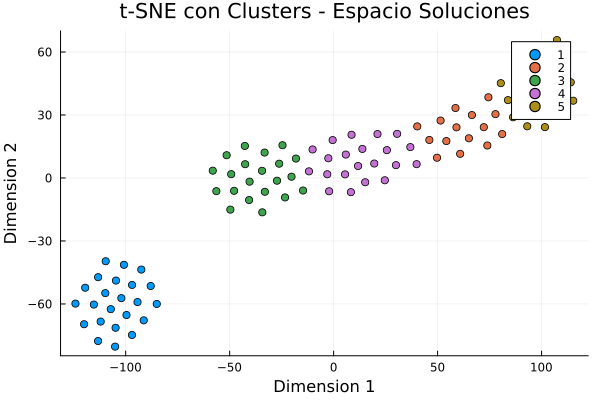

In [76]:
# Grafico del espacio de soluciones
scatter(tsne_result[:, 1], tsne_result[:, 2], group=result.assignments, title="t-SNE con Clusters - Espacio Soluciones", xlabel="Dimension 1", ylabel="Dimension 2", legend=:topright)

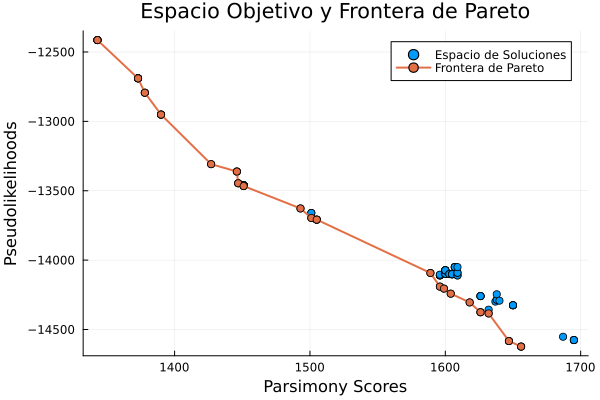

In [74]:
# Grafico del espacio objetivo

Plots.scatter(df_plot.parsimonyScores, df_plot.pseudolikelihoods, label = "Espacio de Soluciones", legend = :topright)
Plots.plot!(pareto_front.parsimonyScores, pareto_front.pseudolikelihoods, label = "Frontera de Pareto", lw = 2, marker = :circle)

xlabel!("Parsimony Scores")
ylabel!("Pseudolikelihoods")
title!("Espacio Objetivo y Frontera de Pareto")

In [77]:
# Mostrar las redes generadas en la frontera de Pareto
println("Redes en la frontera de Pareto:")
println(pareto_front.networksLabel)

Redes en la frontera de Pareto:
["Network 2", "Network 1", "Network 3", "Network 6", "Network 8", "Network 11", "Network 9", "Network 14", "Network 16", "Network 18", "Network 100", "Network 50", "Network 58", "Network 59", "Network 63", "Network 64", "Network 70", "Network 69", "Network 81", "Network 84", "Network 88", "Network 98", "Network 99", "Network 89"]


In [75]:
# Encontrar los índices de las redes en la frontera de Pareto en el arreglo original
pareto_indices = [findfirst(x -> x == label, networksLabel) for label in pareto_front.networksLabel]

# Esto te dará un array con los índices de las redes en la frontera de Pareto
println("Índices de las redes en la frontera de Pareto:")
println(pareto_indices)

Índices de las redes en la frontera de Pareto:
[1, 9, 11, 13, 16, 30, 17, 29, 32, 35, 36, 70, 73, 71, 72, 74, 79, 81, 75, 77]


In [78]:
pareto_front

Row,parsimonyScores,pseudolikelihoods,networksLabel
,Int64,Float64,String
1,2643,-18315.3,Network 2
2,2646,-18327.1,Network 1
3,2648,-18333.3,Network 3
4,2650,-18337.8,Network 6
5,2678,-18604.7,Network 8
6,2679,-18612.1,Network 11
7,2681,-18620.9,Network 9
8,2682,-18628.3,Network 14
9,2695,-18723.0,Network 16


In [78]:
# Lista de marcadores geométricos disponibles
markers = [:octagon, :utriangle, :star5, :diamond, :rect, :star8, :hexagon, :pentagon, :star4, :dtriangle, :octagon, :utriangle, :star5, :diamond, :rect, :star8, :hexagon, :pentagon, :star4, :dtriangle]

# Asignar un marcador a cada red en la frontera de Pareto
pareto_front[!, :marker] = markers[1:nrow(pareto_front)]  # Asegúrate de que haya suficientes marcadores

20-element Vector{Symbol}:
 :octagon
 :utriangle
 :star5
 :diamond
 :rect
 :star8
 :hexagon
 :pentagon
 :star4
 :dtriangle
 :octagon
 :utriangle
 :star5
 :diamond
 :rect
 :star8
 :hexagon
 :pentagon
 :star4
 :dtriangle

In [79]:
# Poner colores a los extremos
# Encontrar los índices de los elementos extremos en la frontera de Pareto
min_index = argmin(pareto_front.parsimonyScores)
max_index = argmax(pareto_front.parsimonyScores)

# Almacenar los índices en un array
extreme_indices = [min_index, max_index]


2-element Vector{Int64}:
  1
 20

In [80]:
# Graficar el espacio objetivo (todas las redes)
scatter(df_plot.parsimonyScores, df_plot.pseudolikelihoods, label = "Red dominada", legend = :topright)

# Graficar la línea de la frontera de Pareto con el color naranja
plot!(pareto_front.parsimonyScores, pareto_front.pseudolikelihoods, label = "Frontera de Pareto", lw = 2, color = :orange)

# Graficar los puntos de la frontera de Pareto con los marcadores asignados y color naranja
for i in 1:nrow(pareto_front)
    scatter!([pareto_front.parsimonyScores[i]], [pareto_front.pseudolikelihoods[i]], 
        marker = (pareto_front.marker[i], 8), label = "", color = :orange)
end

# Resaltar los extremos con el mismo marcador pero sin agregar la leyenda
for i in extreme_indices
    scatter!([pareto_front.parsimonyScores[i]], [pareto_front.pseudolikelihoods[i]], 
        marker = (pareto_front.marker[i], 10), color = :red, label = "")
end

# Agregar una única leyenda con un círculo rojo para "Elementos extremos"
scatter!([NaN], [NaN], marker = (:circle, 10), color = :red, label = "Red extrema")

# Agregar una leyenda adicional con un círculo amarillo para "Red no dominadas"
scatter!([NaN], [NaN], marker = (:circle, 10), color = :orange, label = "Red no dominada")

# Etiquetas y título
xlabel!("Parsimony Scores")
ylabel!("Pseudolikelihoods")
title!("Espacio Objetivo")

#Guardar en pdf de alta resolucion
savefig("./graphs/espacio_objetivo_pareto.pdf")



"c:\\Users\\Israel\\Documents\\Codes\\Taller de investigación\\array-code\\array-code-definitivo\\run3-16s\\graphs\\espacio_objetivo_pareto.pdf"

In [84]:
# Obtener los grupos únicos y ordenarlos
unique_groups = sort(unique(result.assignments))  # Ordenamos los grupos

# Crear etiquetas para los grupos en orden
cluster_labels = ["Grupo $i" for i in unique_groups]

# Graficar el espacio de decisiones (t-SNE) con clusters, arriba a la izquierda, y sin etiquetas automáticas
scatter(tsne_result[:, 1], tsne_result[:, 2], group = result.assignments, 
    label = false,  # Ocultar etiquetas automáticas
    title = "Espacio de Soluciones", xlabel = "Dimension 1", ylabel = "Dimension 2", legend = :topleft)

# Añadir las etiquetas manualmente a la leyenda, en orden
for i in 1:length(unique_groups)
    scatter!([NaN], [NaN], marker = :circle, color = i, label = cluster_labels[i])  # Colores asignados por índice
end

# Resaltar las redes en la frontera de Pareto con los mismos marcadores
for i in 1:nrow(pareto_front)
    scatter!([tsne_result[pareto_indices[i], 1]], [tsne_result[pareto_indices[i], 2]], 
        marker = (pareto_front.marker[i], 8), label = "", color = :orange)
end

# Resaltar los extremos con el mismo marcador, pero sin agregar la leyenda
for i in extreme_indices
    idx = pareto_indices[i]  # Obtener el índice en el espacio de decisiones
    scatter!([tsne_result[idx, 1]], [tsne_result[idx, 2]], 
        marker = (pareto_front.marker[i], 10), color = :red, label = "")
end

# Agregar una única leyenda con un círculo rojo para "Elementos extremos"
scatter!([NaN], [NaN], marker = (:circle, 10), color = :red, label = "Elementos extremos")

# Agregar una leyenda adicional con un círculo amarillo para "Red no dominada"
scatter!([NaN], [NaN], marker = (:circle, 10), color = :orange, label = "Red no dominada")

#Guardar en pdf de alta resolución
savefig("./graphs/espacio_solucion_tsne.pdf")


"c:\\Users\\Israel\\Documents\\Codes\\Taller de investigación\\array-code\\array-code-definitivo\\run3-16s\\graphs\\espacio_solucion_tsne.pdf"

# Resumen de esta ejecución:
---HIV2_72---
N = 24 - numero de redes en la frontera de pareto
k = 5  - numero de clusters
Jaccard index = 0.359